In [13]:
import pandas as pd
data = pd.read_csv('XAU-1h-2020-2024.csv', sep=';')
data= data.dropna().set_index('time')
data['output'] = data['ADX'].shift(-10)
data = data[:-10]
data['output']= data['output'].rolling(window=10).mean()
data = data[9:]
data

/var/folders/cb/8_wl6znx3lgfjfwm_556qshw0000gn/T/ipykernel_93788/1090006067.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('XAU-15-2014-2018.csv', sep=';')


ADX    RSI  Stationary  output
time                                                 
2014.01.02 18:00:00  14.47  64.31      -0.002  14.699
2014.01.02 19:00:00  14.36  65.39       0.001  14.505
2014.01.02 20:00:00  13.49  64.75      -0.000  14.258
2014.01.02 21:00:00  15.79  68.57       0.004  14.043
2014.01.02 22:00:00  17.78  62.75      -0.003  14.061
...                    ...    ...         ...     ...
2017.12.29 09:00:00  41.16  66.77      -0.000  35.957
2017.12.29 10:00:00  36.45  62.57      -0.000  36.641
2017.12.29 11:00:00  34.97  68.23       0.001  37.812
2017.12.29 12:00:00  35.21  69.94       0.000  39.226
2017.12.29 13:00:00  35.79  70.66       0.000  40.813

[23558 rows x 4 columns]

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assume data is your DataFrame already loaded with the specified columns and a time-based index
# data.columns should include ['ADX', 'RSI', 'Stationary', 'output']

# --- Step 1: Data Preparation ---
time_step = 5

# Select features and target
features = ['ADX', 'RSI', 'Stationary']
target = 'output'

# --- Step 2: Create sequences for LSTM input ---
def create_sequences(data, target_col, time_step):
    """
    Create sequences of length time_step from the DataFrame.
    data: DataFrame of input features and target.
    target_col: Name of the target column.
    Returns: X, y arrays suitable for LSTM.
    """
    X, y = [], []
    feature_cols = data.columns.drop(target_col)
    for i in range(len(data) - time_step):
        seq_x = data.iloc[i:i+time_step][feature_cols].values
        # predict target at the next time step after the sequence
        seq_y = data.iloc[i+time_step][target_col]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(data, target_col=target, time_step=time_step)

# --- Step 3: Split into training and evaluation sets ---
# Use a simple 80/20 split for training and evaluation
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- Step 4: Build the LSTM model ---
n_features = len(features)  # number of features per time step

model = Sequential()
model.add(LSTM(50, input_shape=(time_step, n_features)))  # LSTM layer with 50 units
model.add(Dense(1))  # output layer for regression

model.compile(optimizer='adam', loss='mse')

model.summary()

# --- Step 5: Train the model ---
epochs = 50
batch_size = 100

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_eval, y_eval)
)

/opt/anaconda3/envs/quant/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,851 (42.39 KB)

 Trainable params: 10,851 (42.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 782.0587 - val_loss: 334.7146
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 214.3035 - val_loss: 175.5489
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118.7062 - val_loss: 138.2194
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102.0039 - val_loss: 117.6828
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82.0855 - val_loss: 100.7785
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71.8851 - val_loss: 89.7941
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.7540 - val_loss: 81.7675
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.3797 - val_loss: 76.4480
Epoch 9/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.2392 - val_loss: 72.7476
Epoch 10/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.1787 - val_loss: 71.2265
Epoch 11/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.4628 - val_loss: 68.2837
Epoch 12/50
189/189 ━

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 56.0768
Evaluation Loss: 57.405677795410156
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


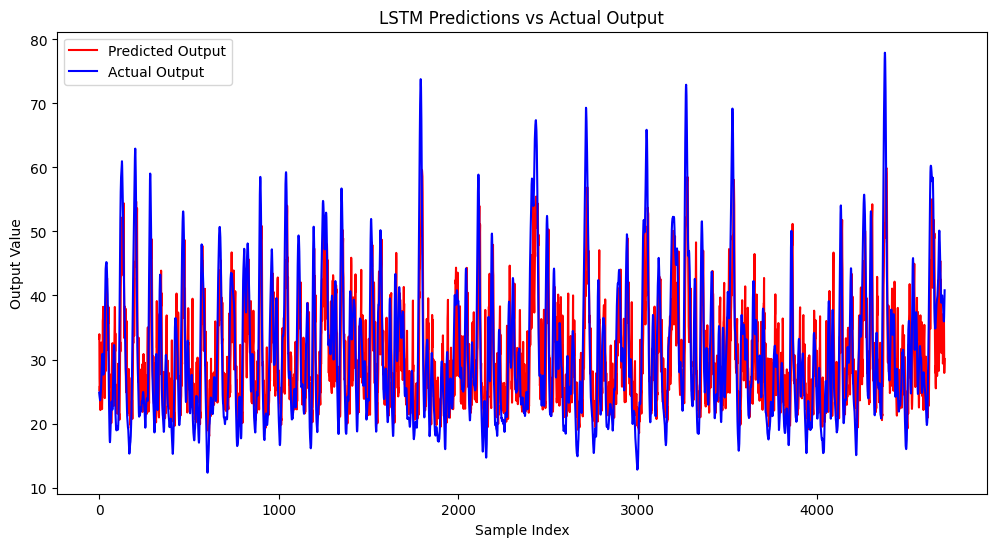

In [15]:
# --- Step 6: Evaluate the model ---
eval_loss = model.evaluate(X_eval, y_eval)
print(f"Evaluation Loss: {eval_loss}")
# --- Step 7: Generate Predictions and Plot ---

# Generate predictions on the evaluation set
predictions = model.predict(X_eval).flatten()

# Create a plot for predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Predicted Output', color='red')
plt.plot(y_eval, label='Actual Output', color='blue')
plt.title('LSTM Predictions vs Actual Output')
plt.xlabel('Sample Index')
plt.ylabel('Output Value')
plt.legend()
plt.show()


In [16]:
import tensorflow as tf
import tf2onnx

# Define the input shape based on your LSTM requirements: (time_step, n_features)
time_step = 5
n_features = 3

# Create a new Keras Input layer matching the shape of your data
inputs = tf.keras.Input(shape=(time_step, n_features), name="input")

# Pass the input through your existing sequential model
outputs = model(inputs)  
functional_model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Create an input signature that matches the defined input shape
input_signature = (
    tf.TensorSpec((None, time_step, n_features), dtype=tf.float32, name="input"),
)

output_path = "regression2024.onnx"

# Convert the functional model to ONNX format
onnx_model, _ = tf2onnx.convert.from_keras(
    functional_model,
    input_signature=input_signature,  # matching the input signature
    opset=15,                         
    output_path=output_path
)

print(f"Model successfully converted to ONNX at {output_path}")


I0000 00:00:1736996704.981623 34204003 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1736996704.981688 34204003 single_machine.cc:361] Starting new session
I0000 00:00:1736996705.063520 34204003 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1736996705.063586 34204003 single_machine.cc:361] Starting new session


Model successfully converted to ONNX at regression2018.onnx
